In [1]:
from src.evaluation.run import performance

In [2]:
perf_svm = performance('linear_svm', {'C': 0.04773295631615594,
  'max_iter': 5000,
  'dual': True,
  'class_weight': {0: 1.0, 1: 2.2, 2: 2.1, 3: 2.4, 4: 2.7, 5: 1.8, 6: 7.6},
  'random_state': 1000}, big=True)

(61302, 233075)


In [ ]:
perf_svm

{'aggregated': {'precision_macro': 0.7232505043136442,
  'recall_macro': 0.7547220510054756,
  'f1_macro': 0.7348762037777813},
 'per_class': {'precision': array([0.77453581, 0.75108225, 0.84552476, 0.64321926, 0.81945163,
         0.60148883, 0.62745098]),
  'recall': array([0.76943347, 0.8414161 , 0.85760369, 0.54776039, 0.94005935,
         0.50061958, 0.82616179]),
  'f1': array([0.77197621, 0.7936871 , 0.85152139, 0.59166424, 0.87562189,
         0.54643823, 0.71322437]),
  'support': array([4554, 2062, 2170, 1853, 1685, 2421,  581])},
 'confusion_matrix': array([[3504,  176,   71,  195,   53,  467,   88],
        [  76, 1735,   89,   53,   26,   54,   29],
        [  83,  110, 1861,   54,    9,   26,   27],
        [ 224,  117,  102, 1015,  128,  205,   62],
        [  25,    8,    3,   41, 1584,   22,    2],
        [ 590,  146,   69,  200,  127, 1212,   77],
        [  22,   18,    6,   20,    6,   29,  480]])}

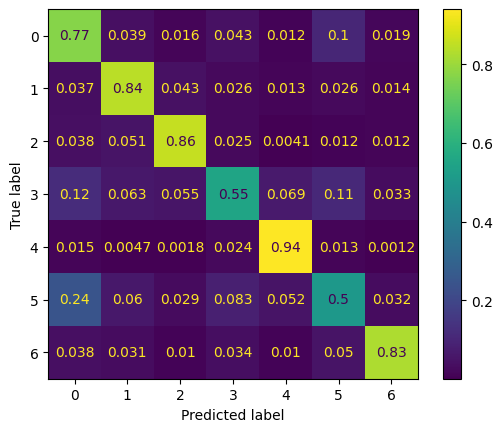

In [ ]:
conf_matr = perf_svm['confusion_matrix']
cm_norm = conf_matr / conf_matr.sum(axis=1, keepdims=True)
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=range(0,7), cmap)
disp.plot();

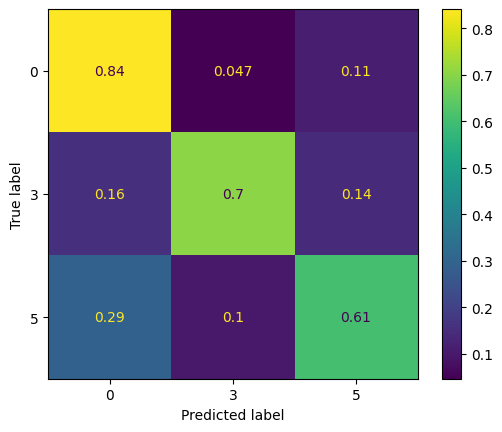

In [7]:
import numpy as np
idx = [0, 3, 5]
sub_cm = conf_matr[np.ix_(idx, idx)]
sub_cm = sub_cm / sub_cm.sum(axis=1, keepdims=True)

disp = ConfusionMatrixDisplay(confusion_matrix=sub_cm,
                              display_labels=[0,3,5])

disp.plot();

In [ ]:
from src.preprocessing import build_preprocess


from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import f1_score
from sklearn.base import clone
import numpy as np

import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import f1_score
from sklearn.base import clone


def tune_k_for_target_classes(
    X_df, y,
    base_clf,
    target_labels,
    numeric_cols,
    k_grid=(500, 1000, 2000, 5000, 10000),
    cv_splits=5,
    random_state=42,
    scoring_mix=(0.7, 0.3),
):
    skf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    best = {"k": None, "score": -np.inf, "details": None}

    for k in k_grid:
        scores = []

        for tr_idx, va_idx in skf.split(X_df, y):
            Xtr, Xva = X_df.iloc[tr_idx], X_df.iloc[va_idx]
            ytr, yva = y[tr_idx], y[va_idx]

            text_prep = build_preprocess("chi2_test", big=True, svd=False) 
            extras_prep = ColumnTransformer(
                transformers=[
                    ("source", OneHotEncoder(handle_unknown="ignore"), ["source"]),
                    ("num", StandardScaler(), numeric_cols),
                ],
                remainder="drop"
            )

            text_branch = Pipeline([
                ("prep", text_prep),
                ("fs", SelectKBest(chi2, k=k)),
            ])

            full_features = FeatureUnion([
                ("text", text_branch),
                ("extras", extras_prep),
            ])

            pipe = Pipeline([
                ("features", full_features),
                ("clf", clone(base_clf)),
            ])

            pipe.fit(Xtr, ytr)
            pred = pipe.predict(Xva)

            target_f1 = f1_score(yva, pred, labels=target_labels, average="macro", zero_division=0)
            macro = f1_score(yva, pred, average="macro", zero_division=0)
            score = scoring_mix[0] * target_f1 + scoring_mix[1] * macro
            scores.append((score, target_f1, macro))

        mean_score  = float(np.mean([s[0] for s in scores]))
        mean_target = float(np.mean([s[1] for s in scores]))
        mean_macro  = float(np.mean([s[2] for s in scores]))

        if mean_score > best["score"]:
            best = {"k": k, "score": mean_score, "details": {"target_f1": mean_target, "macro_f1": mean_macro}}

    return best



In [ ]:
from sklearn.svm import LinearSVC
from src.utils import load_data
from src.config import *

numeric_cols = [
    "page_rank",
    "timestamp_missing",
    "year",
    "len_article",
    "len_title",
    "dayofweek",
    "month",
    "hour"
]

params = {'C': 0.04773295631615594,
  'max_iter': 5000,
  'dual': True,
  'class_weight': {0: 1.0, 1: 2.2, 2: 2.1, 3: 2.4, 4: 2.7, 5: 1.8, 6: 7.6},
  'random_state': 1000}
base_clf = LinearSVC(**params)

news_df = load_data(DEVELOPMENT_PATH)

X = news_df.drop(columns=['y'])
y = news_df['y']

tune_k_for_target_classes(X, y, base_clf, numeric_cols=numeric_cols)